In [1]:
import pandas as pd
from pathlib import Path
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
from statsmodels.stats.multitest import multipletests
from scipy.cluster.hierarchy import linkage, leaves_list

In [2]:
# PARAMETERS
run_id="group_loops.09.19.ldcts"

In [3]:
# Parameters
run_id = "hyper_DMRs.09.19.ldcts"


In [4]:
selected_traits = {
    "Bellenguez.NatGenet.2022.Alzheimers_Disease_Dementia_" : "Alzheimers Disease and Dementia", 
    "Nalls.LancetNeurol.2019.Parkinsons_disease_" : "Parkinson's Disease", 
    "PGC.Nature.2014.Schizophrenia_" : "Schizophrenia", 
    "Wray.biorxiv.2018.Major_Depressive_Disorder_" : "Major Depressive Disorder", 
    "Demontis.NatGenet.2019.Attention_Deficit_Hyperactivity_Disorder_" : "ADHD", 
    "Mullins.NatGenet.2021.Bipolar_Disorder_" : "Bipolar Disorder", 
    "Grove.NatGenet.2019.Autism_Spectrum_Disorder_" : "Autism Spectrum Disorder", 
    "Jansen.2019.NatGenet.Insomnia_" : "Insomnia", 
    "PGC.MolPsychiatry.2017.Obsessive_Compulsive_Disorder_" : "Obsessive Compulsive Disorder", 
    "Deary.MolPsychiatry.2017.Tiredness_" : "Tiredness", 
    "IMSGC.Science.2019.Multiple_sclerosis_" : "Multiple Sclerosis", 
    "Luciano.NatGenet.2017.Neuroticism_" : "Neuroticism", 
    "Okbay.Nature.2016.Educational_Attainment_" : "Educational Attainment", 
    "Palmer.MolPsych.2021.problematic_opioid_use_" : "Problematic Opioid Use", 
    "Savage.NatGenet.2018.Intelligence_" : "Intelligence", 
    "vanRheenen.NatGenet.2016.Amyotrophic_Lateral_Sclerosis_" : "Amyotrophic Lateral Sclerosis", 
    "Barban.NatGenet.2016.Age_First_Birth_" : "Age at First Birth", 
    "Chiou.Nature.2021.Type_1_diabetes_" : "Type 1 Diabetes", 
    "Watson.2018.NatGenet.Anorexia_Nervosa_" : "Anorexia Nervosa"
}

In [5]:
ldsc_results=f'/anvil/projects/x-mcb130189/rwang22/bican/ldsc/output/{run_id}'
directory = Path(ldsc_results)
dfs = {}

for file in directory.glob(f'*.cell_type_results.txt'):
    cur = pd.read_csv(file, sep = "\t")
    stripped = file.stem.replace(f'_.cell_type_results', "")
    cur["Trait"] = stripped
    dfs[stripped] = cur

In [6]:
combined_df = pd.concat(dfs.values(), ignore_index=True)
combined_df["-log10(pval)"] = -np.log10(combined_df["Coefficient_P_value"])
combined_df["Trait"] = combined_df["Trait"].str.replace(f'{run_id}.cell_type_results', "")
combined_df = combined_df[combined_df["Trait"].isin(selected_traits.keys())] # only predetermined selected traits
combined_df.head()

/tmp/ipykernel_1909963/638502812.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  combined_df["Trait"] = combined_df["Trait"].str.replace(f'{run_id}.cell_type_results', "")


,Name,Coefficient,Coefficient_std_error,Coefficient_P_value,Trait,-log10(pval)
713,CN_ST18_GABA,1.781738e-07,3.991393e-08,0.000004,PGC.Nature.2014.Schizophrenia_,5.395440
714,CN_VIP_GABA,2.477413e-07,5.563090e-08,0.000004,PGC.Nature.2014.Schizophrenia_,5.373869
715,F_M_GATA3_GABA,1.265806e-07,3.147496e-08,0.000029,PGC.Nature.2014.Schizophrenia_,4.539123
716,F_GABA,1.489460e-07,3.830468e-08,0.000050,PGC.Nature.2014.Schizophrenia_,4.297202
717,STR_RSPO2_GABA,2.863066e-07,7.664022e-08,0.000094,PGC.Nature.2014.Schizophrenia_,4.028778


In [7]:
# Perform FDR correction using Benjamini-Hochberg procedure
rejected, q_values, _, _ = multipletests(combined_df["Coefficient_P_value"], alpha=0.05, method='fdr_bh')
combined_df["FDR_BH_corrected"] = q_values

In [8]:
# calculate the FDR p value threshold 
# https://www.r-bloggers.com/2023/07/the-benjamini-hochberg-procedure-fdr-and-p-value-adjusted-explained/

def fdr_bh_adj(df):
    tmp = combined_df.copy()
    tmp["rank"] =  combined_df['Coefficient_P_value'].rank()
    num_tests = len(tmp)
    tmp["adj_pval"] = (num_tests * tmp["Coefficient_P_value"]) / tmp["rank"]

    return tmp


In [9]:
tmp = fdr_bh_adj(combined_df)
# Align indices before comparison
fdr_bh_corrected = combined_df["FDR_BH_corrected"]
adj_pval = tmp["adj_pval"]

print(fdr_bh_corrected.sort_values())

713     0.000525
714     0.000525
2108    0.000525
1767    0.000525
2821    0.000525
          ...   
1487    0.999639
2446    0.999639
2073    0.999639
2448    0.999639
2445    0.999639
Name: FDR_BH_corrected, Length: 589, dtype: float64


In [10]:
print(adj_pval.sort_values())

2108    0.000525
1767    0.000529
2821    0.000616
714     0.000623
713     0.000790
          ...   
2073    1.004384
2445    1.004880
2444    1.005436
1115    1.005645
1487    1.006035
Name: adj_pval, Length: 589, dtype: float64


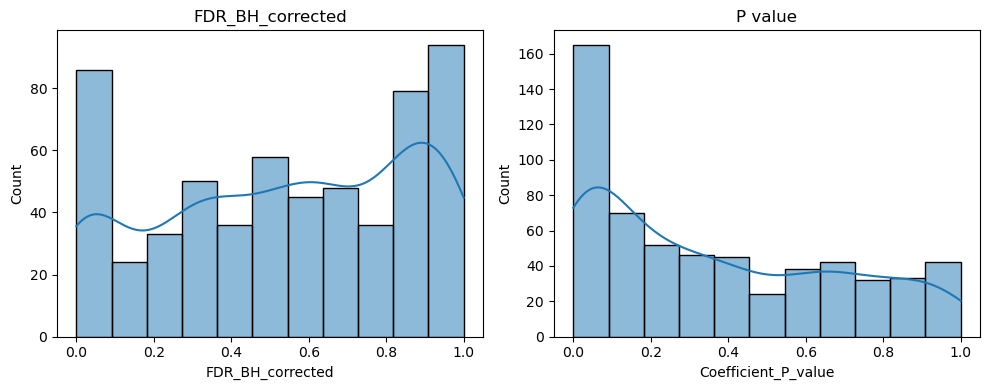

In [11]:
# plot the distribution of p values 
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# First plot
sns.histplot(combined_df["FDR_BH_corrected"], kde=True, ax=axes[0])
axes[0].set_title("FDR_BH_corrected")

# Second plot
sns.histplot(combined_df["Coefficient_P_value"], kde=True, ax=axes[1])
axes[1].set_title("P value")

plt.tight_layout()
plt.show()

In [12]:
modified_df = combined_df.drop(['Coefficient', 'Coefficient_std_error', 'Coefficient_P_value', 'FDR_BH_corrected'], axis=1)
modified_df = modified_df.pivot(index="Name", columns="Trait", values="-log10(pval)").reset_index()
modified_df = modified_df.set_index("Name")
modified_df.head()

Trait,Barban.NatGenet.2016.Age_First_Birth_,Bellenguez.NatGenet.2022.Alzheimers_Disease_Dementia_,Chiou.Nature.2021.Type_1_diabetes_,Deary.MolPsychiatry.2017.Tiredness_,Demontis.NatGenet.2019.Attention_Deficit_Hyperactivity_Disorder_,Grove.NatGenet.2019.Autism_Spectrum_Disorder_,IMSGC.Science.2019.Multiple_sclerosis_,Jansen.2019.NatGenet.Insomnia_,Luciano.NatGenet.2017.Neuroticism_,Mullins.NatGenet.2021.Bipolar_Disorder_,Nalls.LancetNeurol.2019.Parkinsons_disease_,Okbay.Nature.2016.Educational_Attainment_,PGC.MolPsychiatry.2017.Obsessive_Compulsive_Disorder_,PGC.Nature.2014.Schizophrenia_,Palmer.MolPsych.2021.problematic_opioid_use_,Savage.NatGenet.2018.Intelligence_,Watson.2018.NatGenet.Anorexia_Nervosa_,Wray.biorxiv.2018.Major_Depressive_Disorder_,vanRheenen.NatGenet.2016.Amyotrophic_Lateral_Sclerosis_
Name,,,,,,,,,,,,,,,,,,,
ACx_MEIS2_GABA,0.883975,0.158143,0.026371,0.362290,1.296997,0.265800,0.070493,1.034748,2.886673,2.207852,0.591705,1.420986,0.910173,1.330288,0.012174,0.703057,1.212685,1.562991,1.127486
Astrocyte,0.058748,1.592676,0.543517,0.213761,0.187694,1.293999,0.054650,1.270586,0.247959,0.018838,0.399849,0.860740,0.058461,0.022687,0.540515,0.154009,0.039505,0.051426,1.236010
CN_Cholinergic_GABA,0.367846,0.141182,0.001090,0.068388,1.550623,0.856345,0.635021,0.497662,2.517374,3.218976,0.210475,2.052390,0.789705,2.642684,0.180613,2.582101,1.861950,0.581093,1.300205
CN_GABA-Glut,0.951423,0.152820,0.002227,0.200877,0.411934,0.703627,0.614130,1.230571,1.774716,4.205748,0.348510,2.524373,0.329615,3.695028,0.183830,2.140159,1.243266,0.589705,0.738245
CN_LAMP5-CXCL14_GABA,1.491148,0.124345,0.036654,0.106347,4.385027,0.597742,0.348861,1.095964,4.118500,4.020429,0.882210,2.593235,0.171750,3.927343,0.151547,4.142021,2.061171,0.447838,0.576958


In [13]:
fdr_modified_df = combined_df.drop(['Coefficient', 'Coefficient_std_error', 'Coefficient_P_value', '-log10(pval)'], axis=1)
fdr_modified_df = fdr_modified_df.pivot(index="Name", columns="Trait", values="FDR_BH_corrected").reset_index()
fdr_modified_df = fdr_modified_df.set_index("Name")
fdr_modified_df.head()

Trait,Barban.NatGenet.2016.Age_First_Birth_,Bellenguez.NatGenet.2022.Alzheimers_Disease_Dementia_,Chiou.Nature.2021.Type_1_diabetes_,Deary.MolPsychiatry.2017.Tiredness_,Demontis.NatGenet.2019.Attention_Deficit_Hyperactivity_Disorder_,Grove.NatGenet.2019.Autism_Spectrum_Disorder_,IMSGC.Science.2019.Multiple_sclerosis_,Jansen.2019.NatGenet.Insomnia_,Luciano.NatGenet.2017.Neuroticism_,Mullins.NatGenet.2021.Bipolar_Disorder_,Nalls.LancetNeurol.2019.Parkinsons_disease_,Okbay.Nature.2016.Educational_Attainment_,PGC.MolPsychiatry.2017.Obsessive_Compulsive_Disorder_,PGC.Nature.2014.Schizophrenia_,Palmer.MolPsych.2021.problematic_opioid_use_,Savage.NatGenet.2018.Intelligence_,Watson.2018.NatGenet.Anorexia_Nervosa_,Wray.biorxiv.2018.Major_Depressive_Disorder_,vanRheenen.NatGenet.2016.Amyotrophic_Lateral_Sclerosis_
Name,,,,,,,,,,,,,,,,,,,
ACx_MEIS2_GABA,0.382432,0.870712,0.995152,0.691232,0.235422,0.793322,0.949683,0.320304,0.017378,0.052139,0.536296,0.199485,0.368009,0.228889,0.998310,0.476312,0.259667,0.163272,0.296121
Astrocyte,0.957842,0.156132,0.567338,0.839999,0.853381,0.235422,0.962206,0.244873,0.805762,0.996704,0.664024,0.388355,0.957842,0.996473,0.569356,0.872894,0.981364,0.965361,0.257190
CN_Cholinergic_GABA,0.686153,0.885136,0.999639,0.949683,0.165765,0.388586,0.515049,0.600280,0.030331,0.010164,0.839999,0.066410,0.430583,0.025302,0.854591,0.028032,0.093035,0.540327,0.235422
CN_GABA-Glut,0.350376,0.872894,0.999639,0.846768,0.664024,0.476312,0.529904,0.258487,0.108732,0.002445,0.698415,0.030331,0.725632,0.004403,0.854591,0.058430,0.254913,0.536296,0.455993
CN_LAMP5-CXCL14_GABA,0.174398,0.902764,0.982449,0.920934,0.002023,0.536296,0.698415,0.310676,0.002637,0.002958,0.382432,0.027828,0.858467,0.003151,0.872894,0.002637,0.066410,0.632614,0.543595


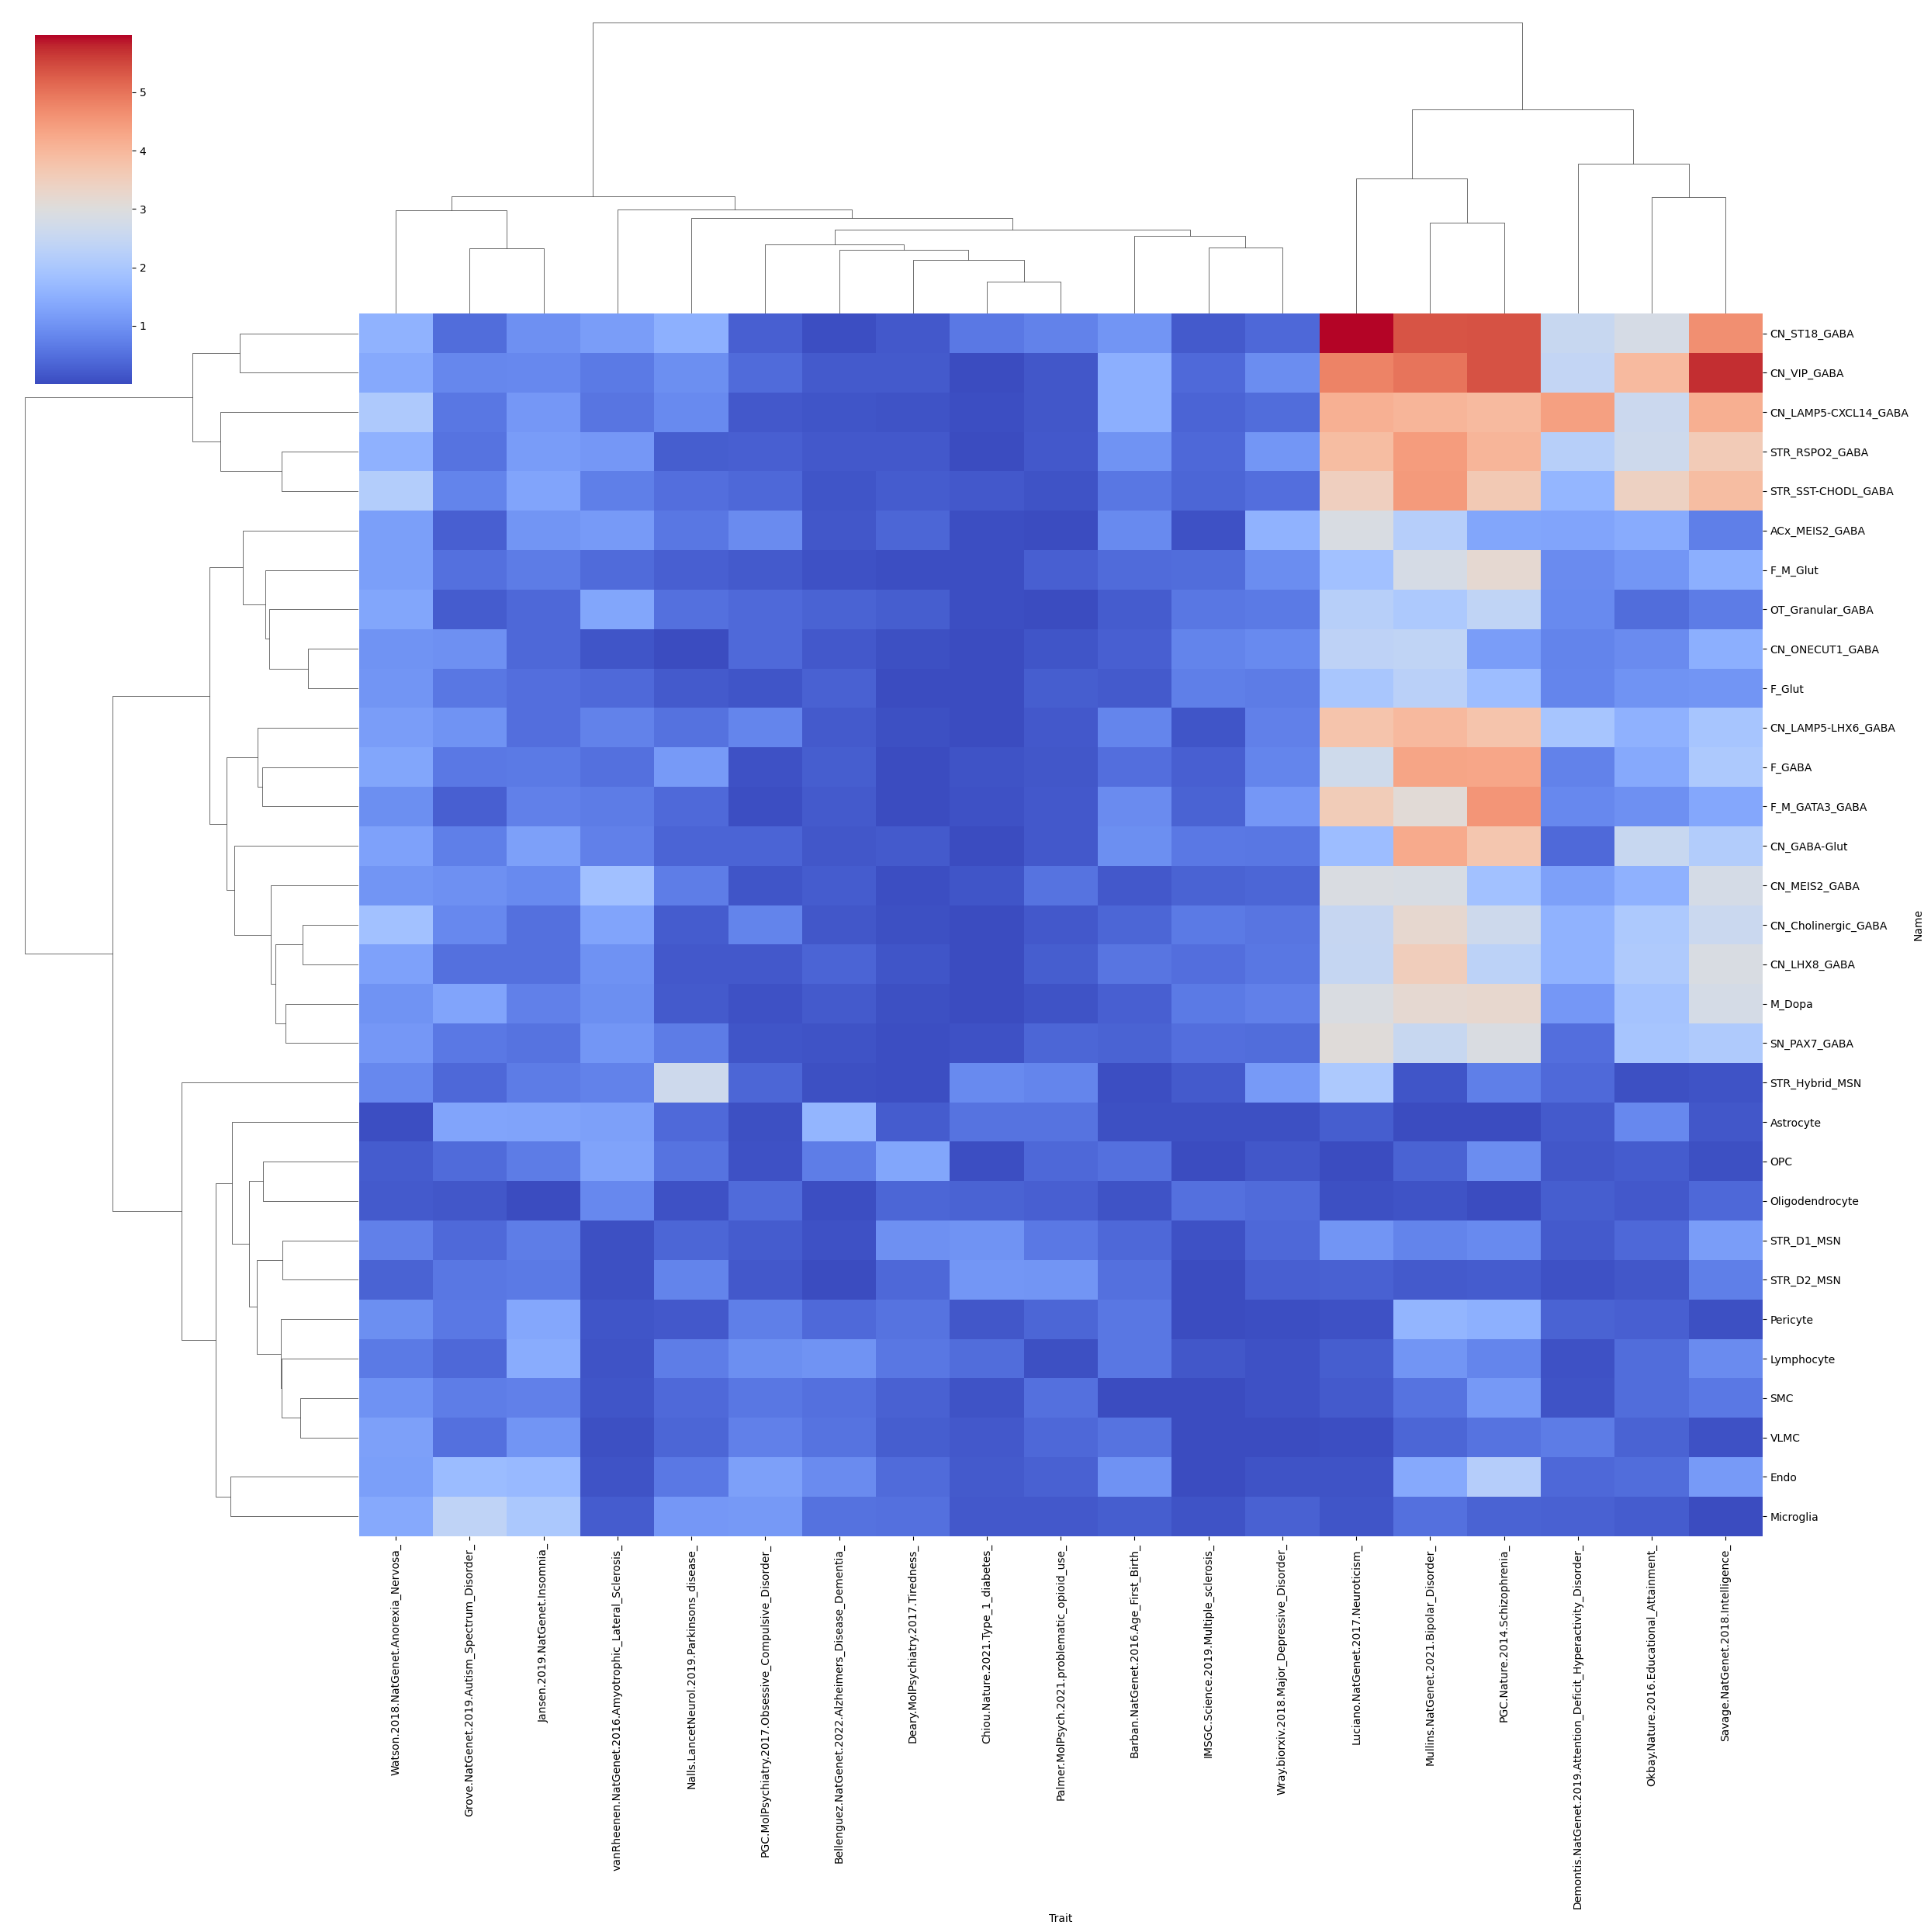

In [14]:
g = sns.clustermap(modified_df, cmap='coolwarm', figsize=(25, 25))

plt.show()
g.savefig(f'output/{run_id}_filtered.pdf')

In [15]:
def pval_to_star(p):
    if p < 1e-7:
        return '***'
    elif p < 1e-5:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return ''

In [16]:
# Cluster rows
linkage_rows = linkage(modified_df.values, method="average", metric="euclidean")
row_order = leaves_list(linkage_rows)

# Cluster columns
linkage_cols = linkage(modified_df.values.T, method="average", metric="euclidean")
col_order = leaves_list(linkage_cols)

modified_df = modified_df.iloc[row_order, col_order].rename(columns = selected_traits)
fdr_modified_df = fdr_modified_df.iloc[row_order, col_order].rename(columns = selected_traits)

In [17]:
fdr_modified_df = fdr_modified_df.reindex(
    index=modified_df.index,    # same row order as df
    columns=modified_df.columns # same column order as df
)

In [18]:
cols_to_keep = fdr_modified_df.loc[:, (fdr_modified_df < 0.05).any()].columns
cols_to_keep

Index(['Autism Spectrum Disorder', 'Parkinson's Disease', 'Neuroticism',
       'Bipolar Disorder', 'Schizophrenia', 'ADHD', 'Educational Attainment',
       'Intelligence'],
      dtype='object', name='Trait')

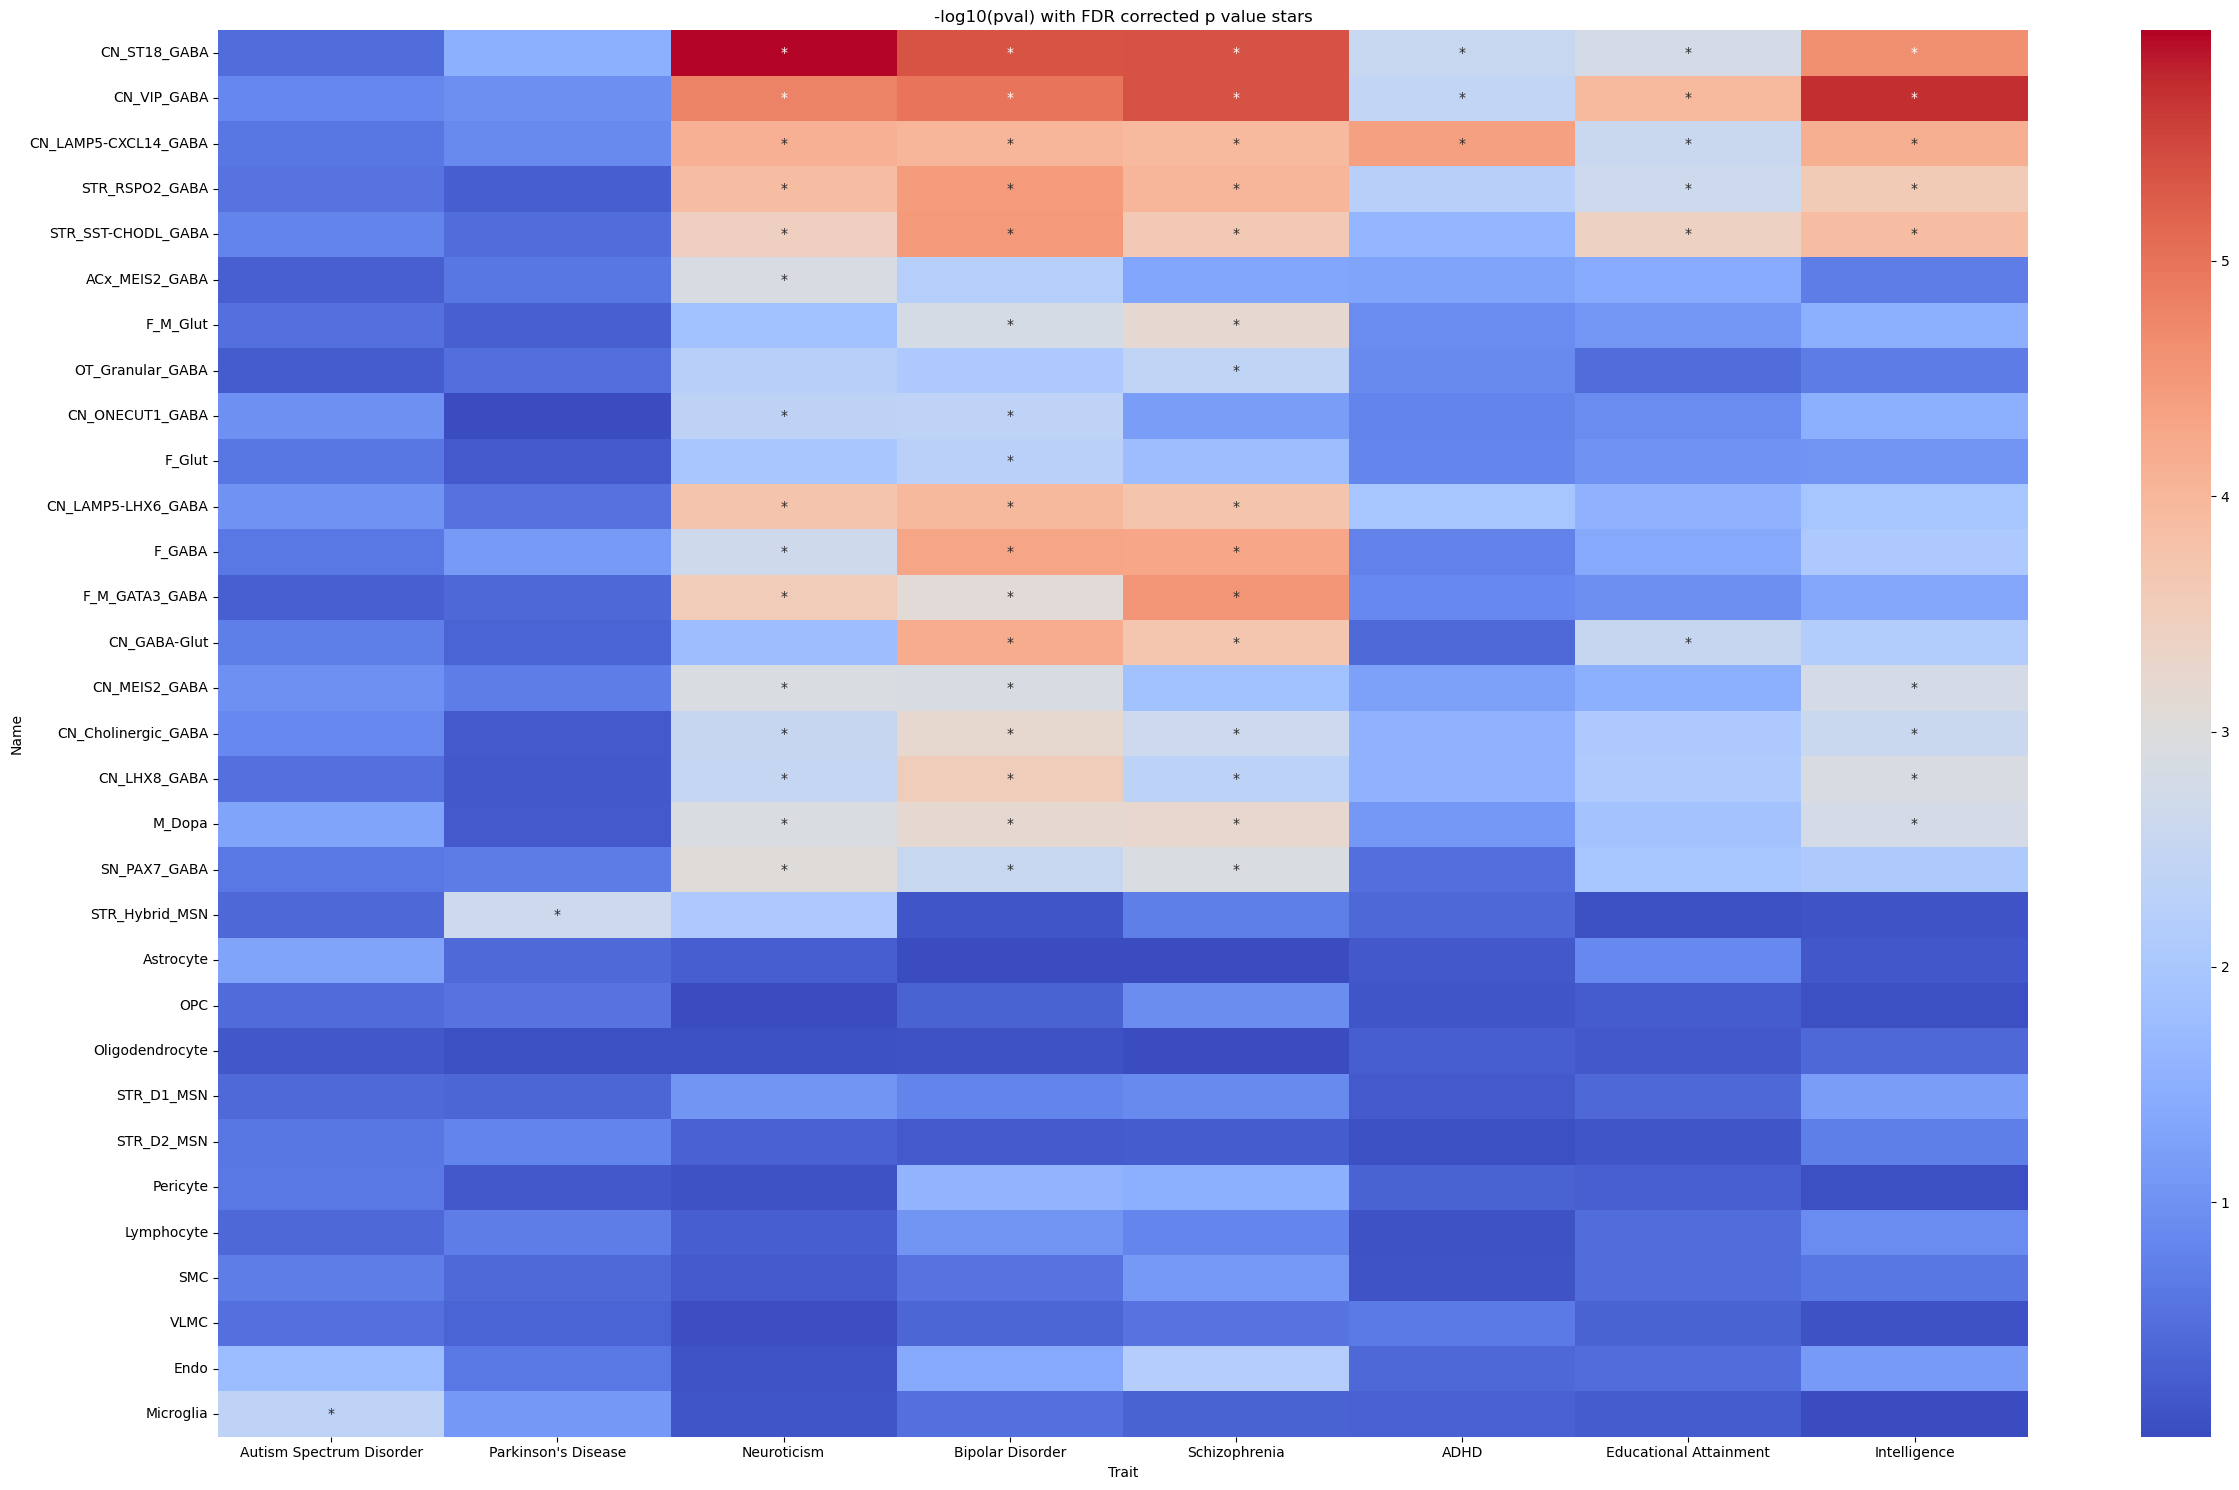

In [19]:
stars = fdr_modified_df[cols_to_keep].applymap(pval_to_star)

# Plot heatmap with annotations
plt.figure(figsize=(25, 15))
sns.heatmap(modified_df[cols_to_keep], annot=stars, fmt='', cmap='coolwarm')
plt.title("-log10(pval) with FDR corrected p value stars")
plt.tight_layout()
plt.savefig(f'output/{run_id}_filtered_FDR_corrected.pdf')
plt.show()

